<a href="https://colab.research.google.com/github/mia2mia/AdversarialNetsPapers/blob/master/signify_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title

!cd
!rm -r *
!git clone https://github.com/anuragajay/signify_demo.git
!mv signify_demo/* .
!rm -r signify_demo
!pip install GPUTil
!pip install tensorboardX
!pip install dominate

import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
sys.path.append('./robustness')
sys.path.append('./cox')
import torch as ch
import numpy as np
import seaborn as sns
from PIL import Image
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.constants import CLASS_DICT
from pathlib import Path
import json
sys.path.append('cycle_gan')
from models import create_model
from util import util
import argparse
%matplotlib inline

# Constants
CONFIG = 'configs/places_room.json'
DATA = 'PlacesRoom' 
BATCH_SIZE = 4
NUM_WORKERS = 8
NOISE_SCALE = 20

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 512 # Size of representation vector (fixed for model)

# Load dataset
file = open(Path('robustness').joinpath(CONFIG))
cfg = json.load(file)
file.close()

dataset_function = getattr(datasets, DATA)
dataset = dataset_function(cfg['data'])

# Load Model
model_kwargs = {
    'arch': 'resnet18',
    'dataset': dataset,
    'resume_path': 'Places_room_adv.pt',
    'old_format': False,
}
model_kwargs['state_dict_path'] = 'model'
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

# Custom loss to maximize a given component of the representation vector
def feature_vis_loss(model, inp, targ):
    _, rep = model(inp, 
                   with_latent=True, 
                   fake_relu=True)
    loss = rep[:, targ]
    return loss, None

# PGD parameters
kwargs = {
    'criterion': ch.nn.CrossEntropyLoss(),
    'custom_loss': feature_vis_loss,
    'constraint':'2',
    'eps':70,
    'step_size': 1,
    'iterations': 200, 
    'use_best': False
}

Img_choice_to_path = {'study room':'./demo_inputs/study_room.jpg',
                      'empty room':'./demo_inputs/living_room.jpg',
                      'living room':'./demo_inputs/living_room2.jpg',
                      'reading room':'./demo_inputs/reading_room.jpg', 
                      'hotel room':'./demo_inputs/hotel_room2.jpg'}

activation_choice_to_num = {'living room 1':146,
                            'living room 2':321,
                            'formal room':68,
                            'meeting room':296,
                            'conference room':338}

filter_type = {'sepia':'hotel_cyclegan', 'blue':'hotel2_cyclegan'}

Cloning into 'signify_demo'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 258 (delta 0), reused 2 (delta 0), pack-reused 254
Receiving objects: 100% (258/258), 163.56 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Checking out files: 100% (215/215), done.
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUTil
     |████████████████████████████████| 225kB 2.8MB/s 
=> loading checkpoint 'Places_room_adv.pt'
=> loaded checkpoint 'Places_room_adv.pt' (epoch 105)


In [0]:
#@title
# Function definitions

def modify_image(src_img, dst_type, model):
    im = ch.tensor(np.transpose(src_img / 255., (0, 3, 1, 2))).float()
    act = activation_choice_to_num[dst_type]
    _, xadv = model(im.clone(), act, make_adv=True, **kwargs)
    return np.transpose(xadv.detach().cpu().numpy(), axes=(0,2,3,1))

def add_filter_image(src_img, filter_color):
    model_name = filter_type[filter_color]
    opt = argparse.Namespace(aspect_ratio=1.0, 
                             batch_size=1, 
                             checkpoints_dir='./cycle_gan/checkpoints', 
                             crop_size=256, dataroot='./cycle_gan/datasets', 
                             dataset_mode='single', 
                             direction='AtoB', 
                             display_id=-1, 
                             display_winsize=256, 
                             epoch='latest', 
                             eval=False, 
                             gpu_ids=[0], 
                             init_gain=0.02, 
                             init_type='normal', 
                             input_nc=3, 
                             isTrain=False, 
                             load_iter=0, 
                             load_size=256, 
                             max_dataset_size=float("inf"), 
                             model='test', 
                             model_suffix='', 
                             n_layers_D=3, 
                             name=model_name, 
                             ndf=64, 
                             netD='basic', 
                             netG='resnet_9blocks', 
                             ngf=64, 
                             no_dropout=True, 
                             no_flip=True, 
                             norm='instance', 
                             ntest=float("inf"), 
                             num_test=50, 
                             num_threads=0, 
                             output_nc=3, 
                             phase='test', 
                             preprocess='resize_and_crop', 
                             results_dir='./cycle_gan/sample_results/', 
                             serial_batches=True, suffix='', 
                             verbose=False)
    filter_model = create_model(opt)
    filter_model.setup(opt)         
    filter_model.eval()
    inp_img = ch.tensor(np.transpose(src_img, axes=(0,3,1,2))).float()
    filter_model.set_input({'A':inp_img, 'A_paths':None})
    filter_model.test()
    visuals = filter_model.get_current_visuals()
    visuals = util.tensor2im(visuals['fake_B'])[None]
    return visuals

def plot_image(src_img, dst_type, filter_color):
    img = np.asarray(Image.open(Img_choice_to_path[src_img]).resize((224, 224)))[None,:]
    mod_img = modify_image(img, dst_type, model)
    filter_mod_img = add_filter_image(mod_img, filter_color)
    print('Original Image')
    plt.imshow(img[0])
    plt.show()
    print('Modified Image')
    plt.imshow(mod_img[0])
    plt.show()
    print('Modified Image+Filter')
    plt.imshow(filter_mod_img[0])
    plt.show()

initialize network with normal
model [TestModel] was created
loading the model from ./cycle_gan/checkpoints/hotel2_cyclegan/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 11.378 M
-----------------------------------------------
Original Image


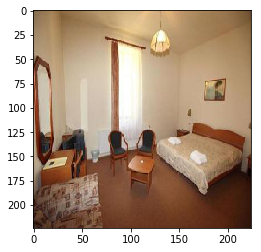

Modified Image


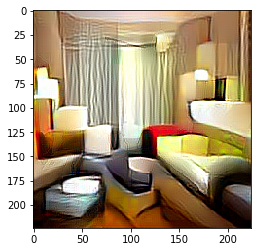

Modified Image+Filter


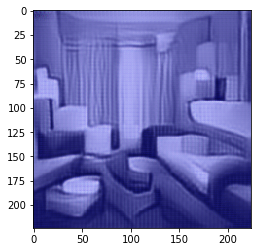

In [0]:
# SOURCE IMAGE CHOICES: study room, living room, empty room, reading room, hotel room
# DESTINATION TYPE CHOICES: living room 1, living room 2, formal room, meeting room, conference room
# FILTER COLOR CHOICES: sepia, blue

plot_image(src_img='hotel room', dst_type='living room 1', filter_color='blue')